# Flow visualization - Oslo City Bike Station Network

### Authors: Niclas Classen & Manuel Knepper
**TL;DR:** This notebook visualizes the flow of bikes between the stations of the Oslo City Bike network. The data for the bike rides is taken from https://oslobysykkel.no/en/open-data and the data for the city districts is taken from https://kartkatalog.dev.geonorge.no/metadata/administrative-enheter-kommuner/041f1e6e-bdbc-4091-b48f-8a5990f3cc5b. The purpose of this notebook is to analyze the flow and cycling patterns of the Oslo City Bike network.

**Reproducibility:** The repository contains the raw and preprocessed data as well as the code to reproduce the analysis. The notebook is written to run from top to bottom.

## Part 1: Data Preprocessing

#### Data Sources:
- Oslo City Bike Data: https://oslobysykkel.no/en/open-data
- Oslo Districts Geojson: https://kartkatalog.dev.geonorge.no/metadata/administrative-enheter-kommuner/041f1e6e-bdbc-4091-b48f-8a5990f3cc5b

#### Data Structure
The data is stored in the following folder structure:
- `data/`: Contains all the raw and preprocessed data
- `data/monthly`: Contains the monthly raw data for the bike rides
- `data/oslo_districts.geojson`: Contains the geojson file of the Oslo districts

It is recommended to use this folder structure as it only requires minor changes in the code to run the analysis.

As result of the data preprocessing, we have the following files:
- `data/preprocessed_bike_rides.csv`: Contains the preprocessed bike rides data of all months

In [18]:
import pandas as pd
import os
from tqdm import tqdm

In [19]:
# Path to your data directory
_path = "/Users/niclasclassen/Code/Master/geospatial-ds-exam/data" #! Change this to your data directory

#### Create one file for all bike rides

In [20]:
# The following runs for 2 minutes on a 2019 MacBook Pro with 16GB RAM

dir_path = os.path.join(_path, 'monthly')

# Directory to export the combined file
export_path = os.path.join(_path)

# Get a list of all csv files in the directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]

# List to hold dataframes for each file
dataframes = []

for file in tqdm(csv_files):
    # Extract year and month from filename
    year, month = file.split('.')[0].split('_')

    # Read csv file into a dataframe
    df = pd.read_csv(os.path.join(dir_path, file))

    # Add a new column for the month and year
    df['month'] = month
    df['year'] = year

    # Check if the DataFrame is not empty or does not contain only NaN values
    if not df.empty and not df.isna().all().all():
        # Append dataframe to the list
        dataframes.append(df)

# Concatenate all dataframes into a single dataframe
if dataframes:
    combined_df = pd.concat(dataframes)

    # Write the combined dataframe to a new csv file in the export directory
    combined_df.to_csv(f'{export_path}/preprocessed_bike_rides.csv', index=False)

100%|██████████| 61/61 [00:32<00:00,  1.89it/s]


## Part 2: Data Analysis

In [24]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from geopandas.tools import sjoin
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler

### Helper functions
First we define some helper functions to load the data that we need for the analysis.

In [22]:
def create_stations_gdf(df: pd.DataFrame, crs_in: int = 4326, crs_out: int = 3857) -> gpd.GeoDataFrame:
    # Create unique dataframes for start and end stations
    start_stations = df[
        [
            "start_station_id",
            "start_station_name",
            "start_station_description",
            "start_station_latitude",
            "start_station_longitude",
            "month",
            "year",
        ]
    ].drop_duplicates()
    end_stations = df[
        [
            "end_station_id",
            "end_station_name",
            "end_station_description",
            "end_station_latitude",
            "end_station_longitude",
            "month",
            "year",
        ]
    ].drop_duplicates()

    # Rename columns for uniformity
    start_stations.columns = [
        "station_id",
        "station_name",
        "station_description",
        "latitude",
        "longitude",
        "month",
        "year",
    ]
    end_stations.columns = [
        "station_id",
        "station_name",
        "station_description",
        "latitude",
        "longitude",
        "month",
        "year",
    ]

    # Concatenate the dataframes
    stations = pd.concat([start_stations, end_stations]).drop_duplicates()
    
    # Create GeoDataFrame
    gdf_stations = gpd.GeoDataFrame(
        stations,
        geometry=gpd.points_from_xy(stations.longitude, stations.latitude),
        crs=crs_in,
    )
    gdf_stations = gdf_stations.to_crs(epsg=crs_out)

    return gdf_stations

def create_rides_gdf(df: pd.DataFrame, crs_in: int = 4326, crs_out: int = 3857) -> gpd.GeoDataFrame:
    # Create a new DataFrame with necessary columns
    df_rides = df[
        [
            "start_station_id",
            "end_station_id",
            "started_at",
            "ended_at",
            "duration",
            "start_station_name",
            "start_station_description",
            "start_station_latitude",
            "start_station_longitude",
            "end_station_name",
            "end_station_description",
            "end_station_latitude",
            "end_station_longitude",
            "month",
            "year",
        ]
    ]

    # Create LineString objects
    df_rides["geometry"] = df_rides.apply(
        lambda row: LineString(
            [
                (row["start_station_longitude"], row["start_station_latitude"]),
                (row["end_station_longitude"], row["end_station_latitude"]),
            ]
        ),
        axis=1,
    )

    # Create GeoDataFrame
    gdf_rides = gpd.GeoDataFrame(df_rides, geometry="geometry", crs=crs_in)
    gdf_rides = gdf_rides.to_crs(epsg=crs_out)
    return gdf_rides

def create_oslo_districts_gdf(
    data_path: str = "data/oslo_districts.geojson",
    crs_in: int = 32633,
    crs_out: int = 3857,
) -> gpd.GeoDataFrame:
    gdf_oslo_districts = gpd.read_file(data_path)
    # Set the correct CRS
    gdf_oslo_districts.set_crs(crs_in, inplace=True, allow_override=True)

    # Reproject the data
    gdf_oslo_districts = gdf_oslo_districts.to_crs(epsg=crs_out)

    # rename columns
    gdf_oslo_districts = gdf_oslo_districts.rename(columns={"bydelnavn": "district"})

    return gdf_oslo_districts

### 2.1 General data analysis

In [23]:
# The following runs for 5 minutes on a 2019 MacBook Pro with 16GB RAM

# Read the preprocessed data
df = pd.read_csv(f'{_path}/preprocessed_bike_rides.csv')

# Create GeoDataFrames for stations and rides
gdf_stations_unfiltered = create_stations_gdf(df)
gdf_stations = gdf_stations_unfiltered.drop_duplicates(subset=['station_id'])
gdf_rides = create_rides_gdf(df)

# gdf_rides from mai 2023 to april 2024
gdf_rides_last_year = gdf_rides[(gdf_rides['year'] == 2023) & (gdf_rides['month'] >= 5) | (gdf_rides['year'] == 2024) & (gdf_rides['month'] < 5)]
gdf_rides_last_year = gdf_rides_last_year.copy()

# Create GeoDataFrame for Oslo districts
gdf_oslo_districts = create_oslo_districts_gdf()

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_42393/264971943.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides["geometry"] = df_rides.apply(


#### 2.1.1 Let's have a first look at the data

##### Oslo Bike Stations

In [26]:
print("Stations gdf unfiltered shape:", gdf_stations_unfiltered.shape)
print("Stations filtered gdf shape:", gdf_stations.shape)
gdf_stations.head(3)

Stations gdf unfiltered shape: (15332, 8)
Stations filtered gdf shape: (286, 8)


station_id         station_name  station_description   latitude  longitude  \
0         507    Jens Bjelkes Gate  ved Trondheimsveien  59.919147  10.764130   
1         607  Marcus Thranes gate        ved Akerselva  59.932772  10.758595   
2         500          Anker Hotel       langs Storgata  59.917279  10.758155   

   month  year                         geometry  
0     10    23  POINT (1198257.424 8381758.913)  
1     10    23  POINT (1197641.308 8384785.559)  
2     10    23  POINT (1197592.370 8381344.042)

In [27]:
gdf_stations.explore()

##### Bike Rides

In [63]:
print("Rides gdf shape:", gdf_rides.shape)
print("Rides gdf of last year shape:", gdf_rides_last_year.shape)
gdf_rides.head(3)

Rides gdf shape: (7897309, 18)
Rides gdf of last year shape: (1106880, 18)


start_station_id  end_station_id                        started_at  \
0               507            2339  2023-10-01 00:00:40.773000+00:00   
1               607             393  2023-10-01 03:01:18.390000+00:00   
2               500             506  2023-10-01 03:06:04.201000+00:00   

                           ended_at  duration   start_station_name  \
0  2023-10-01 00:04:34.682000+00:00       233    Jens Bjelkes Gate   
1  2023-10-01 03:08:24.193000+00:00       425  Marcus Thranes gate   
2  2023-10-01 03:09:44.839000+00:00       220          Anker Hotel   

  start_station_description  start_station_latitude  start_station_longitude  \
0       ved Trondheimsveien               59.919147                10.764130   
1             ved Akerselva               59.932772                10.758595   
2            langs Storgata               59.917279                10.758155   

            end_station_name         end_station_description  \
0                  Elgsletta              langs Nylandsveien   
1  Hans Nielsen Hauges plass  langs Hans Nielsen Hauges gate   
2         Botanisk Hage vest                 ved Blytts gate   

   end_station_latitude  end_station_longitude  month  year  \
0             59.915649              10.761725     10    23   
1             59.939244              10.774319     10    23   
2             59.920128              10.768875     10    23   

                                            geometry  duration_in_minutes  \
0  LINESTRING (1198257.424 8381758.913, 1197989.6...             3.883333   
1  LINESTRING (1197641.308 8384785.559, 1199391.7...             7.083333   
2  LINESTRING (1197592.370 8381344.042, 1198785.7...             3.666667   

   duration_capped  
0         3.883333  
1         7.083333  
2         3.666667

##### Oslo City Districts

In [29]:
print("Oslo districts gdf shape:", gdf_oslo_districts.shape)
gdf_oslo_districts.head(3)

Oslo districts gdf shape: (17, 3)


district bydelnr  \
0            Frogner  030105   
1           Østensjø  030113   
2  Søndre Nordstrand  030115   

                                            geometry  
0  MULTIPOLYGON (((1189421.693 8375826.292, 11864...  
1  MULTIPOLYGON (((1206718.020 8369118.365, 12067...  
2  MULTIPOLYGON (((1210120.108 8358267.151, 12100...

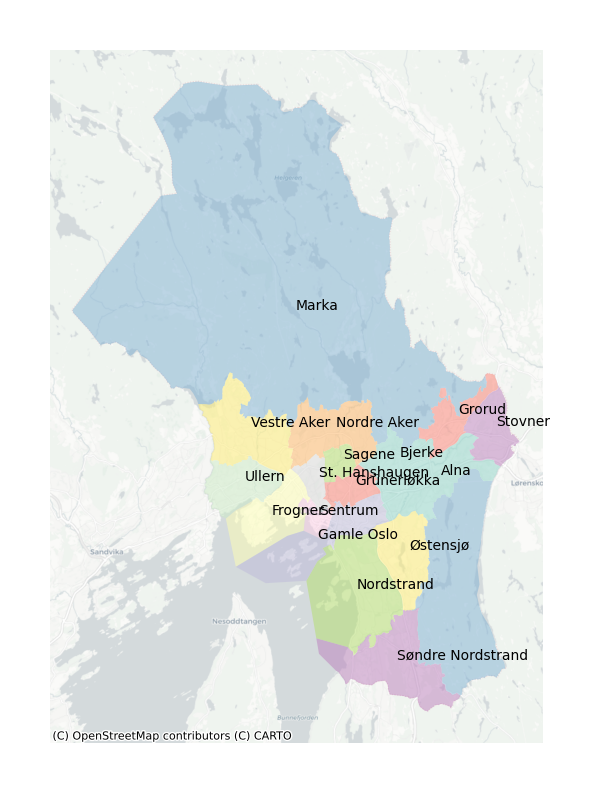

In [30]:
# Plot the unique polygons with stations, with a different color for each district
ax = gdf_oslo_districts.plot(column='district', cmap='Set3', alpha=0.5, figsize=(9, 9))

# Add a basemap
cx.add_basemap(ax, crs=gdf_oslo_districts.crs, source=cx.providers.CartoDB.Positron)

# Add the name of each district
for x, y, label in zip(gdf_oslo_districts.geometry.centroid.x, gdf_oslo_districts.geometry.centroid.y, gdf_oslo_districts['district']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

ax.set_axis_off()
ax.set_aspect('equal')

#### 2.1.2 Change of the station network over the years

In [33]:
# Split the stations GeoDataFrame by year
gdf_stations_by_year = {}
difference_stations_by_year = {}

for year in range(19, 25):
    gdf_stations_by_year[year] = gdf_stations_unfiltered[gdf_stations_unfiltered['year'] == year].drop_duplicates(subset=['station_id'])

    if year != 19:
        difference_stations_by_year[f'{year - 1}_{year}'] = set(gdf_stations_by_year[year]['station_id'].unique()) - set(gdf_stations_by_year[year - 1]['station_id'].unique())
        difference_stations_by_year[f'{year}_{year - 1}'] = set(gdf_stations_by_year[year - 1]['station_id'].unique()) - set(gdf_stations_by_year[year]['station_id'].unique())

In [37]:
# Get number of unique stations for entire dataset and for different years
for year, df in gdf_stations_by_year.items():
    number = df['station_id'].nunique()
    print(f"Number of stations in {year}: {number}")

Number of stations in 19: 254
Number of stations in 20: 255
Number of stations in 21: 262
Number of stations in 22: 269
Number of stations in 23: 273
Number of stations in 24: 268


In [38]:
# Datasets with changes in stations from year to year
stations_change_2019_2020_df = gdf_stations_by_year[20].loc[gdf_stations_by_year[20]['station_id'].isin(list(difference_stations_by_year['19_20']))]
stations_change_2020_2019_df = gdf_stations_by_year[19].loc[gdf_stations_by_year[19]['station_id'].isin(list(difference_stations_by_year['20_19']))]

stations_change_2020_2021_df = gdf_stations_by_year[21].loc[gdf_stations_by_year[21]['station_id'].isin(list(difference_stations_by_year['20_21']))]
stations_change_2021_2020_df = gdf_stations_by_year[20].loc[gdf_stations_by_year[20]['station_id'].isin(list(difference_stations_by_year['21_20']))]

stations_change_2021_2022_df = gdf_stations_by_year[22].loc[gdf_stations_by_year[22]['station_id'].isin(list(difference_stations_by_year['21_22']))]
stations_change_2022_2021_df = gdf_stations_by_year[21].loc[gdf_stations_by_year[21]['station_id'].isin(list(difference_stations_by_year['22_21']))]

stations_change_2022_2023_df = gdf_stations_by_year[23].loc[gdf_stations_by_year[23]['station_id'].isin(list(difference_stations_by_year['22_23']))]
stations_change_2023_2022_df = gdf_stations_by_year[22].loc[gdf_stations_by_year[22]['station_id'].isin(list(difference_stations_by_year['23_22']))]

stations_change_2023_2024_df = gdf_stations_by_year[24].loc[gdf_stations_by_year[24]['station_id'].isin(list(difference_stations_by_year['23_24']))]
stations_change_2024_2023_df = gdf_stations_by_year[23].loc[gdf_stations_by_year[23]['station_id'].isin(list(difference_stations_by_year['24_23']))]

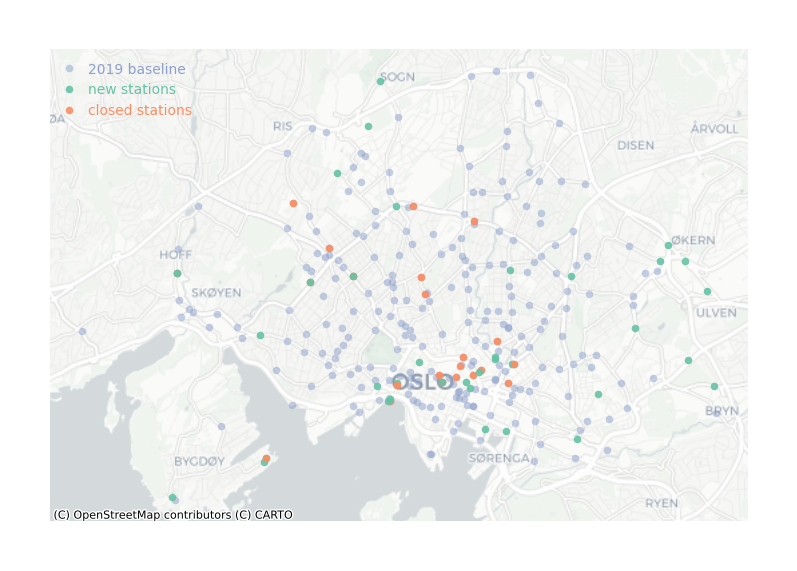

In [58]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_stations_by_year[19].plot(alpha=0.5, ax=ax, color='#8da0cb', markersize=30, label='2019 baseline')
stations_change_2019_2020_df.plot(alpha=0.9, ax=ax, color='#66c2a5', markersize=30)
stations_change_2020_2019_df.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=30)
stations_change_2020_2021_df.plot(alpha=0.9, ax=ax, color='#66c2a5', markersize=30)
stations_change_2021_2020_df.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=30)
stations_change_2021_2022_df.plot(alpha=0.9, ax=ax, color='#66c2a5', markersize=30)
stations_change_2022_2021_df.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=30)
stations_change_2022_2023_df.plot(alpha=0.9, ax=ax, color='#66c2a5', markersize=30)
stations_change_2023_2022_df.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=30)
stations_change_2023_2024_df.plot(alpha=0.9, ax=ax, color='#66c2a5', markersize=30, label='new stations')
stations_change_2024_2023_df.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=30, label='closed stations')
ax.set_axis_off()
plt.legend(labelcolor= ['#8da0cb','#66c2a5', '#fc8d62'],loc='upper left')
cx.add_basemap(ax, crs=gdf_stations_by_year[19].crs, source=cx.providers.CartoDB.Positron)

In [112]:
# TODO: Add plot for each year / moth / season

#### 2.1.3 Basic behavior of the bike rides

##### Distribution of rental durations

In [67]:
# Function to format y-tick labels
def thousands(x, pos):
    return '%1.0fK' % (x * 0.001)

In [76]:
def plot_histogram_of_trip_durations(gdf_rides_input, plot_title):
    
    formatter = FuncFormatter(thousands)

    gdf_rides_input['duration_in_minutes'] = gdf_rides_input['duration'] / 60

    # Create a new column 'duration_capped' where all durations over 100 minutes are set to 100
    gdf_rides_input['duration_capped'] = np.where(gdf_rides_input['duration_in_minutes'] > 100, 100, gdf_rides_input['duration_in_minutes'])

    # Calculate percentiles for the capped durations
    percentiles = np.percentile(gdf_rides_input['duration_capped'], [75])

    # Set the style and color palette of the plot
    sns.set_color_codes('pastel')

    # Create a histogram of the capped durations
    sns.histplot(gdf_rides_input['duration_capped'], bins=50, color='b', edgecolor="none")

    # Add vertical lines for the percentiles
    for percentile in percentiles:
        plt.axvline(x=percentile, color='r', linestyle='--')
        plt.text(percentile+1, plt.gca().get_ylim()[1], '75th percentile', color='r', rotation=90, verticalalignment='top')

    # Set the title and labels of the plot
    plt.title(plot_title, fontsize=13)
    plt.xlabel('Duration (minutes)', fontsize=12)
    plt.ylabel('Number of trips', fontsize=12)

    # Set x-axis labels to increments of 10
    plt.xticks(np.arange(0, max(gdf_rides['duration_capped'])+5, 5))

    # Format y-axis labels to thousands
    plt.gca().yaxis.set_major_formatter(formatter)

    # Remove the top, right, and left spines from plot
    sns.despine(left=True)

    # Show the plot
    plt.show()

/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


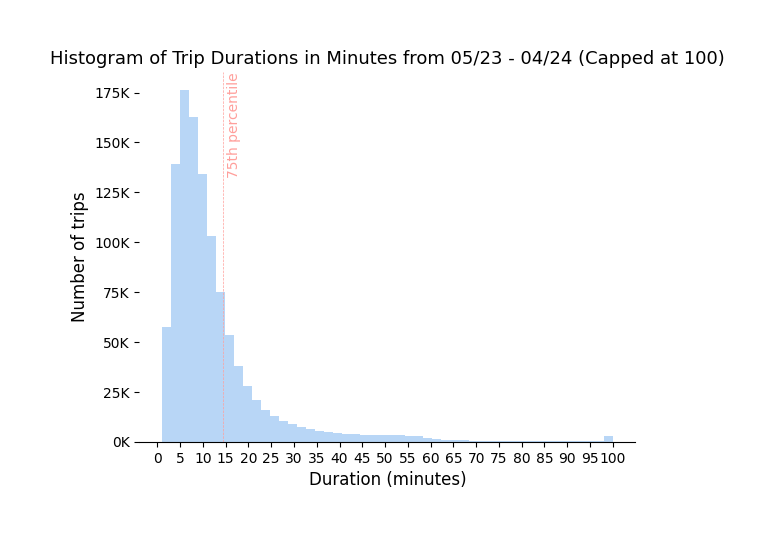

In [78]:
plot_title = 'Histogram of Trip Durations in Minutes from 05/23 - 04/24 (Capped at 100)'
plot_histogram_of_trip_durations(gdf_rides_last_year, plot_title)

In [ ]:
# TODO: Add plot for each year / month /season

##### Number of rides per day

In [79]:
def custom_date_parser(d):
    return parse(d)

In [80]:
def plot_number_of_rides_per_day(gdf_rides_input):
    tqdm.pandas()

    # Convert 'started_at' to datetime format
    gdf_rides_input['started_at_converted'] = gdf_rides_input['started_at'].progress_apply(custom_date_parser)

    # Extract the hour and the day of the week
    gdf_rides_input['day'] = gdf_rides_input['started_at_converted'].dt.day
    gdf_rides_input['hour'] = gdf_rides_input['started_at_converted'].dt.hour
    gdf_rides_input['day_of_week'] = gdf_rides_input['started_at_converted'].dt.dayofweek
    gdf_rides_input['weekday_or_weekend'] = gdf_rides_input['day_of_week'].progress_apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

    bins = list(range(0, 25, 1))  # Create bins for each hour
    labels = [f'{i}-{i+1}' for i in bins[:-1]]  # Create labels for each bin
    gdf_rides_input['hour_interval'] = pd.cut(gdf_rides_input['hour'], bins=bins, labels=labels, right=False)

    # Group by 'day', 'hour_interval', and 'weekday_or_weekend' and count the number of trips
    grouped = gdf_rides_input.groupby(['day_of_week', 'hour_interval', 'weekday_or_weekend']).size().reset_index(name='num_trips')

    # Create the lineplot
    plt.figure(figsize=(15, 8))
    sns.lineplot(data=grouped, x='hour_interval', y='num_trips', hue='weekday_or_weekend')

    # Remove the top, right, and left spines from plot
    sns.despine(left=True)

    plt.show()

In [ ]:
# TODO: fix slice of dataframe error for gdf_rides_last_year

100%|██████████| 1106880/1106880 [01:20<00:00, 13809.66it/s]
/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv

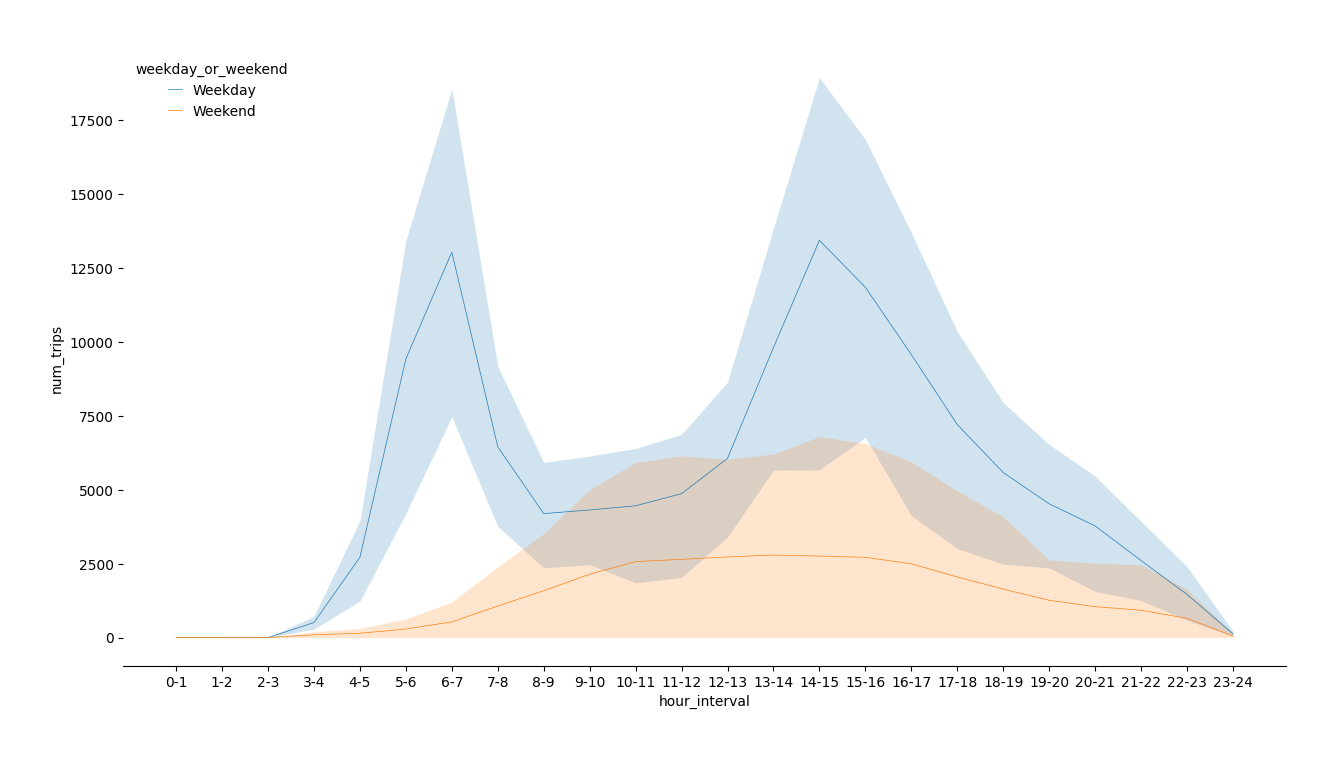

In [81]:
# The following runs for 15 minutes on a 2019 MacBook Pro with 16GB RAM for all the rides and 2 mins for the last year
plot_number_of_rides_per_day(gdf_rides_last_year)

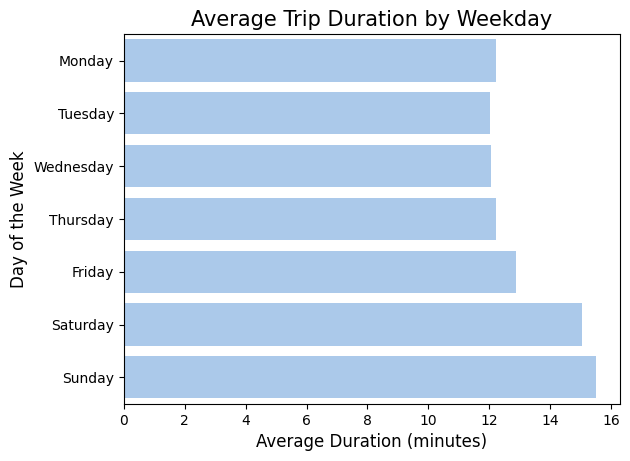

In [148]:
# TODO: create function for the following
# Calculate average duration for each day of the week
average_duration = gdf_rides.groupby('day_of_week')['duration_in_minutes'].mean()

# Create a new DataFrame for the plot
df_average_duration = pd.DataFrame({'day_of_week': average_duration.index, 'average_duration': average_duration.values})

# Create a list of weekdays in order
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Map 'day_of_week' from numerical to string
df_average_duration['day_of_week'] = df_average_duration['day_of_week'].map(dict(enumerate(weekdays)))

# Convert 'day_of_week' from string to categorical data
df_average_duration['day_of_week'] = pd.Categorical(df_average_duration['day_of_week'], categories=weekdays, ordered=True)

# Sort the DataFrame by 'day_of_week'
df_average_duration = df_average_duration.sort_values('day_of_week')

# Set the color palette
sns.set_color_codes('pastel')

# Create the plot with flipped axes and pastel color
sns.barplot(x='average_duration', y='day_of_week', data=df_average_duration, color='b', orient='h')

# Set the title and labels of the plot
plt.title('Average Trip Duration by Weekday', fontsize=15)
plt.xlabel('Average Duration (minutes)', fontsize=12)
plt.ylabel('Day of the Week', fontsize=12)

# Show the plot
plt.show()

In [ ]:
# TODO: Add plot for each year / month / season

### 2.2 Flow analysis

#### 2.2.1 Flow between stations

In [12]:
# Drop duplicates and count the number of rides for each combination
gdf_rides_unique = gdf_rides.drop_duplicates(subset=['start_station_id','end_station_id'])

# Count the number of rides for each combination and add as a new column
gdf_rides_unique['count'] = gdf_rides.groupby(['start_station_id','end_station_id'])['start_station_id'].transform('count')
print(gdf_rides_unique.shape)
gdf_rides_unique.head(3)

(76819, 17)


/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


start_station_id  end_station_id                        started_at  \
0               507            2339  2023-10-01 00:00:40.773000+00:00   
1               607             393  2023-10-01 03:01:18.390000+00:00   
2               500             506  2023-10-01 03:06:04.201000+00:00   

                           ended_at  duration   start_station_name  \
0  2023-10-01 00:04:34.682000+00:00       233    Jens Bjelkes Gate   
1  2023-10-01 03:08:24.193000+00:00       425  Marcus Thranes gate   
2  2023-10-01 03:09:44.839000+00:00       220          Anker Hotel   

  start_station_description  start_station_latitude  start_station_longitude  \
0       ved Trondheimsveien               59.919147                10.764130   
1             ved Akerselva               59.932772                10.758595   
2            langs Storgata               59.917279                10.758155   

            end_station_name         end_station_description  \
0                  Elgsletta              langs Nylandsveien   
1  Hans Nielsen Hauges plass  langs Hans Nielsen Hauges gate   
2         Botanisk Hage vest                 ved Blytts gate   

   end_station_latitude  end_station_longitude  month  year  \
0             59.915649              10.761725     10    23   
1             59.939244              10.774319     10    23   
2             59.920128              10.768875     10    23   

                                            geometry  count  
0  LINESTRING (1198257.424 8381758.913, 1197989.6...    142  
1  LINESTRING (1197641.308 8384785.559, 1199391.7...    111  
2  LINESTRING (1197592.370 8381344.042, 1198785.7...    191

In [13]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(np.array(list(gdf_rides_unique['count'])).reshape(-1, 1))
gdf_rides_unique_scaled = gdf_rides_unique.copy()
gdf_rides_unique_scaled['count'] = np.clip(min_max_scaler.transform(np.array(list(gdf_rides_unique['count'])).reshape(-1, 1)), 0, 1)

print("max", gdf_rides_unique_scaled['count'].max())

max 1.0


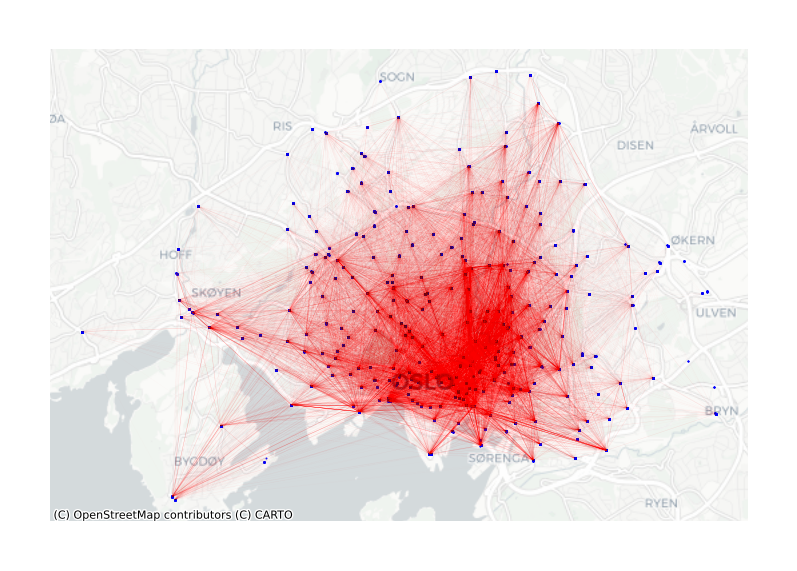

In [17]:
# TODO: maybe find a better way to plot it
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_rides_unique_scaled.plot(linewidth= 0.3, alpha=gdf_rides_unique_scaled['count'], ax=ax, color='red')
gdf_stations.plot(alpha=0.9, markersize=2, ax=ax, color='blue')
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf_stations.crs, source=cx.providers.CartoDB.Positron)

In [172]:
# TODO: Add plot for each year / month / season

##### Flow of new stations

In [ ]:
# TODO: Clean up the following code

In [173]:
gdf_stations_2019 = gdf_stations.loc[gdf_stations['year'] == 19]
gdf_stations_2024 = gdf_stations.loc[gdf_stations['year'] == 24]
stations_2019 = gdf_stations_2019['station_id'].unique()
stations_2024 = gdf_stations_2024['station_id'].unique()
difference_19_24 = set(stations_2024) - set(stations_2019)
stations_change_2024_2019_df = gdf_stations_2024.loc[gdf_stations_2024['station_id'].isin(list(difference_19_24))]

In [175]:
rides_new_stations_start = gdf_rides.loc[gdf_rides['start_station_id'].isin(list(difference_19_24))]
rides_new_stations_end = gdf_rides.loc[gdf_rides['end_station_id'].isin(list(difference_19_24))]

In [176]:
frames = [rides_new_stations_start, rides_new_stations_end]
rides_new_stations = pd.concat(frames)

In [177]:
# Preprocessing
gdf_rides_unique_19_24 = rides_new_stations.drop_duplicates(subset=['start_station_id','end_station_id'])
rides_count_19_24 =rides_new_stations.groupby(['start_station_id', 'end_station_id'])['start_station_latitude'].count()
testdf_19_24 = pd.DataFrame(data=rides_count_19_24.index, columns=['station_ids'])
testdf2_19_24 = pd.DataFrame(data=rides_count_19_24.values, columns=['count'])
rides_count_19_24_df = pd.merge(testdf_19_24, testdf2_19_24, left_index=True, right_index=True)
rides_count_19_24_df[['start_station_id','end_station_id']] = rides_count_19_24_df.station_ids.apply( 
   lambda x: pd.Series(str(x).split(","))) 
rides_count_19_24_df['start_station_id'] = rides_count_19_24_df['start_station_id'].str[1:]
rides_count_19_24_df['end_station_id'] = rides_count_19_24_df['end_station_id'].str.rstrip(')')
rides_count_19_24_df['start_station_id'] = pd.to_numeric(rides_count_19_24_df['start_station_id'])
rides_count_19_24_df['end_station_id'] = pd.to_numeric(rides_count_19_24_df['end_station_id'])
gdf_rides_unique_count_19_24 = pd.merge(gdf_rides_unique_19_24, rides_count_19_24_df, 'inner',on=['start_station_id', 'end_station_id'])

In [178]:
min_max_scaler_19_24 = MinMaxScaler()
min_max_scaler_19_24.fit(np.array(list(gdf_rides_unique_count_19_24['count'])).reshape(-1, 1))
gdf_rides_unique_count_19_24_scaled = gdf_rides_unique_count_19_24.copy()
gdf_rides_unique_count_19_24_scaled['count'] = min_max_scaler_19_24.transform(np.array(list(gdf_rides_unique_count_19_24['count'])).reshape(-1, 1))

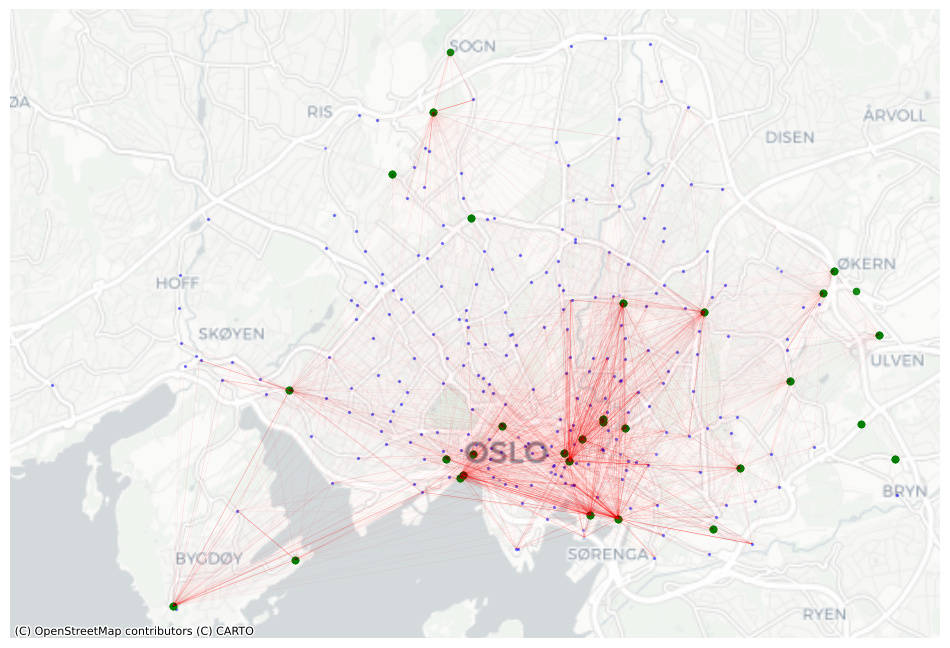

In [180]:
f, ax = plt.subplots(1, figsize=(12, 12))
gdf_rides_unique_count_19_24_scaled.plot(linewidth= 0.3, alpha=gdf_rides_unique_count_19_24_scaled['count'], ax=ax, color='red')
gdf_stations_2019.plot(alpha=0.05, markersize=2, ax=ax, color='blue')
stations_change_2024_2019_df.plot(alpha=0.9, markersize=20, ax=ax, color='green')
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf_stations_2024.crs, source=cx.providers.CartoDB.Positron)

##### Flow between districts

In [18]:
# Perform a spatial join between the stations and the districts
joined = sjoin(gdf_stations, gdf_oslo_districts, how='left', op='within')

# The 'district' column in 'joined' now contains the district of each station
gdf_stations['district'] = joined['district']
gdf_stations.head(5)

/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


station_id         station_name  station_description   latitude  longitude  \
0         507    Jens Bjelkes Gate  ved Trondheimsveien  59.919147  10.764130   
1         607  Marcus Thranes gate        ved Akerselva  59.932772  10.758595   
2         500          Anker Hotel       langs Storgata  59.917279  10.758155   
3         599            Paléhaven     langs Strandgata  59.910331  10.750110   
4         597          Fredensborg    ved rundkjøringen  59.920995  10.750358   

   month  year                         geometry        district  
0     10    23  POINT (1198257.424 8381758.913)     Grünerløkka  
1     10    23  POINT (1197641.308 8384785.559)          Sagene  
2     10    23  POINT (1197592.370 8381344.042)     Grünerløkka  
3     10    23  POINT (1196696.771 8379801.076)         Sentrum  
4     10    23  POINT (1196724.378 8382169.263)  St. Hanshaugen

In [19]:
# Create a dictionary from unique_polygons DataFrame
district_dict = gdf_stations.set_index('station_id')['district'].to_dict()

# Use the map function on the start_station_id and end_station_id columns
gdf_rides['start_district'] = gdf_rides['start_station_id'].map(district_dict)
gdf_rides['end_district'] = gdf_rides['end_station_id'].map(district_dict)
district_dict

{507: 'Grünerløkka',
 607: 'Sagene',
 500: 'Grünerløkka',
 599: 'Sentrum',
 597: 'St. Hanshaugen',
 598: 'Grünerløkka',
 522: 'Gamle Oslo',
 407: 'Sagene',
 404: 'Frogner',
 617: 'St. Hanshaugen',
 401: 'Grünerløkka',
 2305: 'Grünerløkka',
 525: 'Sagene',
 384: 'St. Hanshaugen',
 440: 'Gamle Oslo',
 2304: 'Gamle Oslo',
 424: 'Grünerløkka',
 412: 'Grünerløkka',
 472: 'Sagene',
 446: 'St. Hanshaugen',
 470: 'St. Hanshaugen',
 383: 'St. Hanshaugen',
 410: 'Sagene',
 548: 'Frogner',
 2358: 'Frogner',
 2308: 'St. Hanshaugen',
 564: 'Frogner',
 2351: 'Nordre Aker',
 578: 'St. Hanshaugen',
 461: 'Gamle Oslo',
 624: 'Grünerløkka',
 499: 'St. Hanshaugen',
 511: 'Frogner',
 398: 'Sagene',
 462: 'St. Hanshaugen',
 480: 'Gamle Oslo',
 423: 'Grünerløkka',
 540: 'Sagene',
 506: 'Grünerløkka',
 382: 'St. Hanshaugen',
 568: 'Frogner',
 626: 'Frogner',
 485: 'Gamle Oslo',
 388: 'Frogner',
 738: 'Gamle Oslo',
 421: 'Grünerløkka',
 535: 'Frogner',
 3725: 'St. Hanshaugen',
 542: 'Grünerløkka',
 563: 'Frog

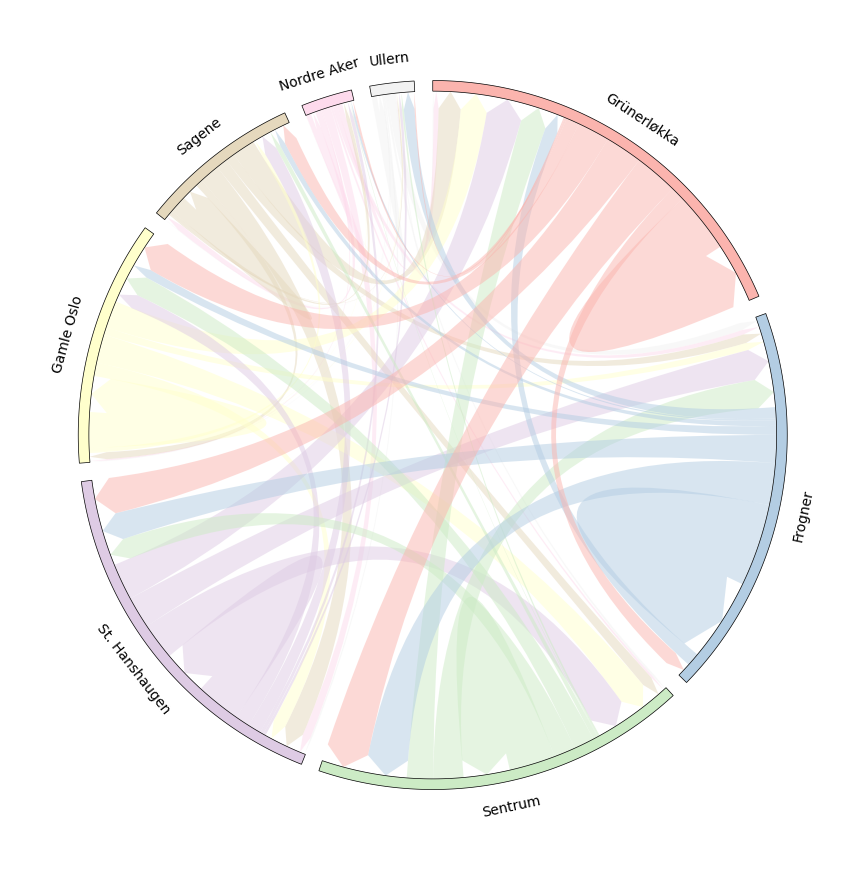

In [20]:
# Concatenate start_district and end_district
districts = pd.concat([gdf_rides['start_district'], gdf_rides['end_district']])

top_districts = districts.value_counts().head(8)
filtered_gdf_rides = gdf_rides[gdf_rides['start_district'].isin(top_districts.index) & gdf_rides['end_district'].isin(top_districts.index)]

# Create from-to table dataframe & convert to matrix
from_to_table = filtered_gdf_rides.groupby(['start_district', 'end_district']).size().unstack().fillna(0)
matrix_df = pd.DataFrame(from_to_table, index=top_districts.index, columns=top_districts.index)

circos = Circos.initialize_from_matrix(
    matrix_df,
    space=3,
    cmap="Pastel1",  # Change colormap to 'Pastel1'
    label_kws=dict(size=10, r=105),
    link_kws=dict(direction=1, ec="black", lw=0),
)
fig = circos.plotfig()

In [195]:
# TODO: Add plot for each year / month / season

In [7]:
# TODO: add map with with lines/arrows between the districts

### 2.3 Cluster analysis

To get an initial idea of the distribution of the variable 'Pct_Leave', let's make a quick choropleth map:

### Choropleth map (starting from)

In [125]:
# TODO maybe start with a clean df for all tasks

In [83]:
stations_24 = gdf_stations_by_year[24].drop_duplicates(subset='station_id')

In [86]:
# remove all rides where start_station_id or end_station_id is not in the stations_24
gdf_rides_with_valid_stations = gdf_rides_last_year.loc[gdf_rides_last_year['start_station_id'].isin(stations_24['station_id']) & gdf_rides_last_year['end_station_id'].isin(stations_24['station_id'])]
gdf_rides_with_valid_stations.shape

(1083570, 24)

In [87]:
# create choropleth map

# Perform a spatial join between the stations and the districts
joined = sjoin(stations_24, gdf_oslo_districts, how='left', op='within')

# The 'district' column in 'joined' now contains the district of each station
stations_24['district'] = joined['district']
stations_24.head(3)

/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


station_id station_name station_description   latitude  longitude  \
6360154         403    Parkveien   ved trikkestoppet  59.921768  10.730476   
6360155         464  Sukkerbiten       ved gangbroen  59.905124  10.753764   
6360156         426   Gimle Kino   ved Frogner Kirke  59.917281  10.708376   

         month  year                         geometry district  
6360154      4    24  POINT (1194511.124 8382340.955)  Frogner  
6360155      4    24  POINT (1197103.483 8378645.102)  Sentrum  
6360156      4    24  POINT (1192050.941 8381344.349)  Frogner

In [88]:
# Group gdf_rides by 'start_station_id' and count the number of rides
rides_start = gdf_rides_with_valid_stations.groupby('start_station_id').size().reset_index(name='num_rides_start')
stations_2024 = stations_24.merge(rides_start, left_on='station_id', right_on='start_station_id', how='left')

# Group gdf_rides by 'end_station_id' and count the number of rides
rides_end = gdf_rides_with_valid_stations.groupby('end_station_id').size().reset_index(name='num_rides_end')
stations_2024 = stations_2024.merge(rides_end, left_on='station_id', right_on='end_station_id', how='left')
stations_2024.shape

(268, 13)

In [89]:
#  group and sum number of start and end rides
district_rides_start = stations_2024.groupby('district')['num_rides_start'].sum().reset_index(name='num_rides_start')
district_rides_end = stations_2024.groupby('district')['num_rides_end'].sum().reset_index(name='num_rides_end')

# merge
gdf_oslo_districts = gdf_oslo_districts.merge(district_rides_start, on='district', how='left')
gdf_oslo_districts = gdf_oslo_districts.merge(district_rides_end, on='district', how='left')
gdf_oslo_districts.shape

(17, 5)

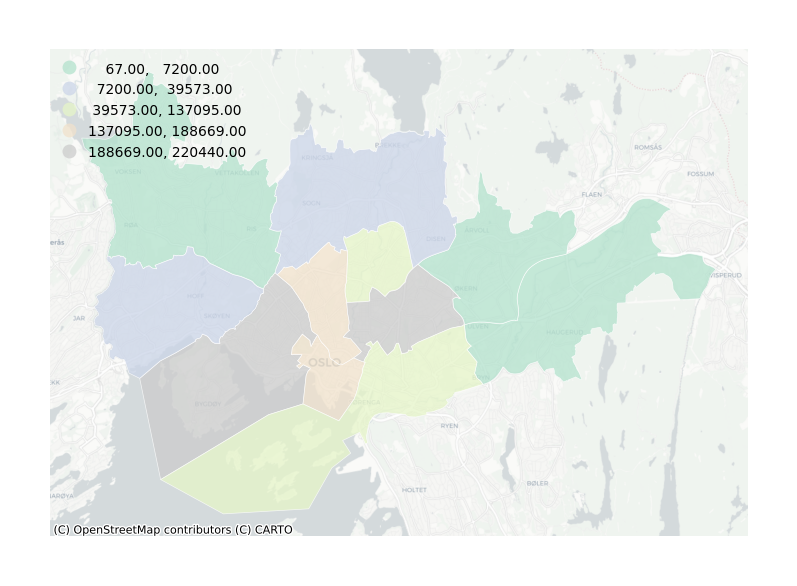

In [90]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_oslo_districts.plot(
    column="num_rides_start",
    cmap="Pastel2",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.5,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
cx.add_basemap(
    ax,
    crs=gdf_oslo_districts.crs,
    source=cx.providers.CartoDB.Positron
)
ax.set_axis_off()

### Morans I

Moran's I: 0.2992533614323409, p-value: 0.001


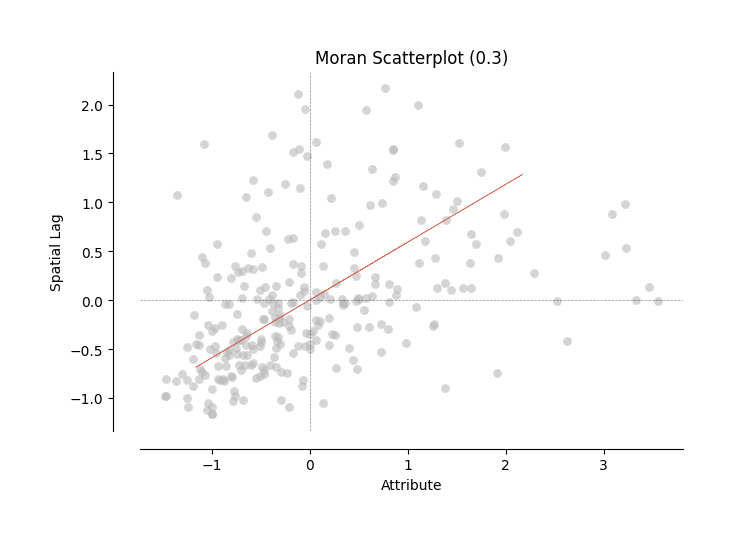

In [103]:
# KNN morans I
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot

# Create a weights object using k-nearest neighbors
w = weights.KNN.from_dataframe(stations_2024, k=3, ids='station_id')

# Calculate Moran's I
moran = esda.Moran(stations_2024['num_rides_start'], w)

# Print Moran's I statistic and p-value
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

# Create a Moran's plot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

### Lisa

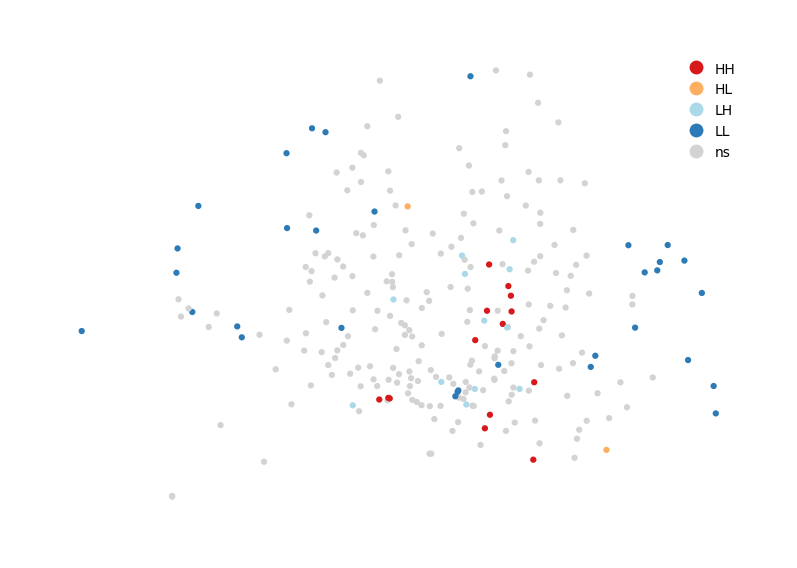

In [104]:
# LISA
from splot.esda import lisa_cluster

# Calculate local Moran's I
lisa = esda.Moran_Local(stations_2024['num_rides_start'], w)

# Create a LISA cluster map
fig, ax = lisa_cluster(lisa, stations_2024, p=0.05, figsize=(9, 9))

## Find new stations

In [112]:
import osmnx as ox

# Define the area of interest
area_of_interest = 'Oslo, Norway'

# Download the OSM data for water in the area of interest
gdf_water = ox.geometries_from_place(area_of_interest, tags={'natural':'water'})

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_42393/1479495765.py:7: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf_water = ox.geometries_from_place(area_of_interest, tags={'natural':'water'})


In [113]:
import geopandas as gpd
from shapely.geometry import Polygon
from itertools import combinations
from scipy.spatial import cKDTree
import numpy as np

In [158]:
k_stations = 10
x = 3
k = 3
c = 3

new_stations = gpd.GeoDataFrame(columns=['geometry'], crs=stations_2024.crs) 

# only 10 stations from stations_2024
gdf_stations_input = stations_2024.sample(n=k_stations)
for i in range(x):
    print(gdf_stations_input.shape)

    # Step 1: Create all possible combinations of x stations
    combinations_of_stations = list(combinations(gdf_stations_input.geometry, x))

    # Step 2: Create polygons with progress bar
    polygons = [Polygon(points) for points in tqdm(combinations_of_stations)]

    # Step 3: Store polygons in a new GeoDataFrame
    gdf_polygons = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_stations_input.crs)

    # Calculate the centroids of all polygons
    gdf_polygons['centroid'] = gdf_polygons['geometry'].centroid

    # Step 1: Calculate the distance from each centroid to its closest c stations
    tree = cKDTree(np.array(list(zip(stations_2024.geometry.x, stations_2024.geometry.y))))
    distances, indices = tree.query(np.array(list(zip(gdf_polygons['centroid'].x, gdf_polygons['centroid'].y))), k=c)

    # Step 2: TODO: add comment
    min_distances = distances.min(axis=1)
    furthest_centroids = gdf_polygons['centroid'].loc[np.argsort(min_distances)[-1:]]


    # Create a new GeoDataFrame for furthest_centroids
    gdf_furthest_centroids = gpd.GeoDataFrame(furthest_centroids, geometry='centroid', crs=stations_2024.crs)

    # rename centroid to geometry
    gdf_furthest_centroids = gdf_furthest_centroids.rename(columns={'centroid': 'geometry'})

    for furthest_centroid in gdf_furthest_centroids['geometry']:
        print(furthest_centroid)
        # check if point is in water
        in_water = any(furthest_centroid.within(polygon) for polygon in gdf_water['geometry'])
        if in_water:
            continue
        else:
            # add 
            gdf_stations_input = pd.concat([gdf_stations_input, gpd.GeoDataFrame({'geometry': [furthest_centroid]}, crs=stations_2024.crs)])
            new_stations = pd.concat([new_stations, gpd.GeoDataFrame({'geometry': [furthest_centroid]}, crs=stations_2024.crs)])
            break

    

(10, 13)


100%|██████████| 120/120 [00:00<00:00, 9966.86it/s]


POINT (1191990.0699381148 8378893.349523057)
(11, 13)


100%|██████████| 165/165 [00:00<00:00, 10583.58it/s]


POINT (1192768.7862682666 8378787.417285607)
(12, 13)


100%|██████████| 220/220 [00:00<00:00, 10816.14it/s]

POINT (1192768.7862682666 8378787.417285607)


In [152]:
gdf_stations_input

station_id                 station_name    station_description  \
48       1023.0   Professor Aschehougs plass  ved Kristian IVs gate   
49        491.0                      Brugata    ved Chr Kroghs gate   
154       737.0                    Munkegata        langs Oslo gate   
80        387.0              Studenterlunden       langs Karl Johan   
104      2305.0             Hesselbergs Gate        ved Toftes Gate   
253       560.0               Gaustad T-bane    langs Slemdalsveien   
221       450.0                   Elisenberg       ved holdeplassen   
209       618.0  Bak Niels Treschows hus sør    nærmest trikkestopp   
257      2355.0                 Økern T-bane       langs Ulvenveien   
143       548.0            Colbjørnsens gate          ved Skovveien   
0           NaN                          NaN                    NaN   
0           NaN                          NaN                    NaN   
0           NaN                          NaN                    NaN   
0           NaN                          NaN                    NaN   
0           NaN                          NaN                    NaN   
0           NaN                          NaN                    NaN   
0           NaN                          NaN                    NaN   
0           NaN                          NaN                    NaN   
0           NaN                          NaN                    NaN   
0           NaN                          NaN                    NaN   

      latitude  longitude  month  year                         geometry  \
48   59.914767  10.740971    4.0  24.0  POINT (1195679.422 8380786.144)   
49   59.913661  10.757294    4.0  24.0  POINT (1197496.451 8380540.519)   
154  59.908255  10.767800    4.0  24.0  POINT (1198666.013 8379340.141)   
80   59.914586  10.735453    4.0  24.0  POINT (1195065.161 8380745.906)   
104  59.927778  10.761256    4.0  24.0  POINT (1197937.585 8383675.968)   
253  59.945955  10.710392    4.0  24.0  POINT (1192275.384 8387715.183)   
221  59.919524  10.708840    4.0  24.0  POINT (1192102.616 8381842.548)   
209  59.942473  10.723715    4.0  24.0  POINT (1193758.521 8386941.170)   
257  59.928895  10.806235    4.0  24.0  POINT (1202944.553 8383924.113)   
143  59.917319  10.716909    4.0  24.0  POINT (1193000.857 8381352.811)   
0          NaN        NaN    NaN   NaN  POINT (1193011.587 8385336.388)   
0          NaN        NaN    NaN   NaN  POINT (1196077.174 8385658.561)   
0          NaN        NaN    NaN   NaN  POINT (1195924.427 8385425.233)   
0          NaN        NaN    NaN   NaN  POINT (1195924.427 8385425.233)   
0          NaN        NaN    NaN   NaN  POINT (1195924.427 8385425.233)   
0          NaN        NaN    NaN   NaN  POINT (1195924.427 8385425.233)   
0          NaN        NaN    NaN   NaN  POINT (1195924.427 8385425.233)   
0          NaN        NaN    NaN   NaN  POINT (1195924.427 8385425.233)   
0          NaN        NaN    NaN   NaN  POINT (1195924.427 8385425.233)   
0          NaN        NaN    NaN   NaN  POINT (1195924.427 8385425.233)   

        district  start_station_id  num_rides_start  end_station_id  \
48       Sentrum            1023.0           5828.0          1023.0   
49   Grünerløkka             491.0           2712.0           491.0   
154   Gamle Oslo             737.0           7480.0           737.0   
80       Sentrum             387.0           3576.0           387.0   
104  Grünerløkka            2305.0           3710.0          2305.0   
253  Vestre Aker             560.0            366.0           560.0   
221      Frogner             450.0           4214.0           450.0   
209  Nordre Aker             618.0           2048.0           618.0   
257       Bjerke            2355.0            708.0          2355.0   
143      Frogner             548.0           2452.0           548.0   
0            NaN               NaN              NaN             NaN   
0            NaN               NaN              NaN             NaN   
0            N

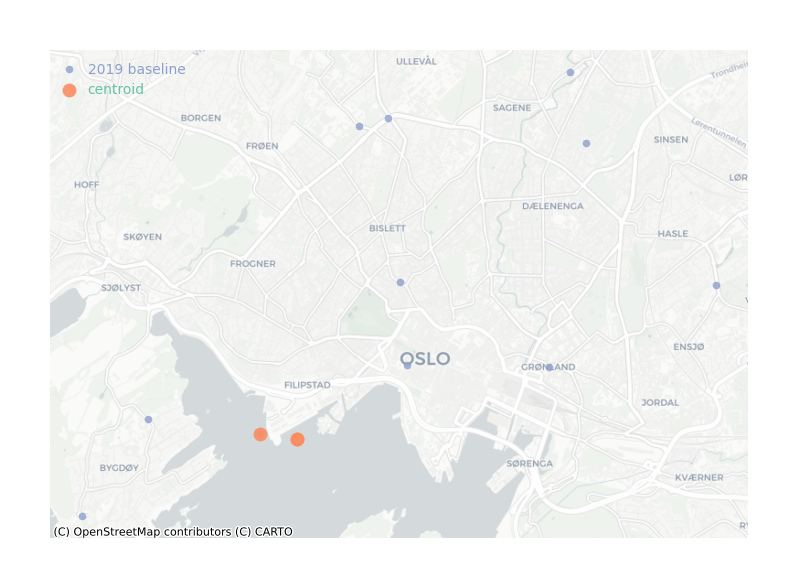

In [159]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_stations_input.plot(alpha=0.8, ax=ax, color='#8da0cb', markersize=30, label='2019 baseline')
new_stations.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=100, label='centroid')

ax.set_axis_off()
plt.legend(labelcolor= ['#8da0cb','#66c2a5', '#fc8d62'],loc='upper left')
cx.add_basemap(ax, crs=stations_2024.crs, source=cx.providers.CartoDB.Positron)

In [119]:
k = 4

# unique stations of 2024
stations_2024 = gdf_stations_by_year[24].drop_duplicates(subset='station_id')
stations_2024

station_id        station_name              station_description  \
6360135         403           Parkveien                ved trikkestoppet   
6360136         464         Sukkerbiten                    ved gangbroen   
6360137         426          Gimle Kino                ved Frogner Kirke   
6360138         394   Bjølsen Studentby                ved rundkjøringen   
6360139         521  Jess Carlsens gate               ved Hausmanns gate   
...             ...                 ...                              ...   
6394825         545         Arkaden Sør           langs Dronningens gate   
6398328         551     Olaf Ryes plass             langs Sofienberggata   
6422242         576    Dronningens gate               sør for Karl Johan   
6833639         508   Majorstuen T-bane  ved passasje mot Sørkedalsveien   
6864862         549        Linaaes gate                 langs Møllergata   

          latitude  longitude  month  year                         geometry  
6360135  59.921768  10.730476      4    24  POINT (1194511.124 8382340.955)  
6360136  59.905124  10.753764      4    24  POINT (1197103.483 8378645.102)  
6360137  59.917281  10.708376      4    24  POINT (1192050.941 8381344.349)  
6360138  59.943778  10.760121      4    24  POINT (1197811.205 8387231.202)  
6360139  59.918636  10.752394      4    24  POINT (1196951.014 8381645.305)  
...            ...        ...    ...   ...                              ...  
6394825  59.911969  10.747858      4    24  POINT (1196446.113 8380164.804)  
6398328  59.922425  10.758182      4    24  POINT (1197595.342 8382486.885)  
6422242  59.911392  10.747282      4    24  POINT (1196381.941 8380036.728)  
6833639  59.929857  10.714566      2    24  POINT (1192740.058 8384137.907)  
6864862  59.913824  10.745704      1    24  POINT (1196206.351 8380576.678)  

[268 rows x 8 columns]

In [120]:
import geopandas as gpd
from shapely.geometry import Polygon

# Step 1: Calculate the nearest neighbors
distances = stations_2024.geometry.apply(lambda x: stations_2024.distance(x))
distances.name = "distance"
nearest = distances.apply(lambda x: x.nsmallest(k+1).iloc[-1])
nearest.name = "nearest"

# Step 2: Create polygons
polygons = []
for station in stations_2024.itertuples():
    neighbors = distances.loc[station.Index].nsmallest(k+1).index
    points = stations_2024.loc[neighbors, 'geometry'].tolist()
    polygon = Polygon(points)
    polygons.append(polygon)

# Step 3: Store polygons in a new GeoDataFrame
gdf_polygons = gpd.GeoDataFrame({'geometry': polygons}, crs=stations_2024.crs)
gdf_polygons


geometry
0    POLYGON ((1194511.124 8382340.955, 1194831.836...
1    POLYGON ((1197103.483 8378645.102, 1197228.284...
2    POLYGON ((1192050.941 8381344.349, 1192102.616...
3    POLYGON ((1197811.205 8387231.202, 1197833.775...
4    POLYGON ((1196951.014 8381645.305, 1197229.769...
..                                                 ...
263  POLYGON ((1196446.113 8380164.804, 1196467.754...
264  POLYGON ((1197595.342 8382486.885, 1197288.701...
265  POLYGON ((1196381.941 8380036.728, 1196483.884...
266  POLYGON ((1192740.058 8384137.907, 1192641.580...
267  POLYGON ((1196206.351 8380576.678, 1196323.916...

[268 rows x 1 columns]

In [121]:
# Calculate the area of each polygon
gdf_polygons['area'] = gdf_polygons['geometry'].area

# Find the top 5 polygons with the largest area
largest_polygons = gdf_polygons.nlargest(5, 'area')
largest_polygons

geometry          area
128  POLYGON ((1203843.965 8379546.450, 1203782.081...  2.384127e+06
18   POLYGON ((1189653.921 8379211.146, 1190901.363...  2.096225e+06
52   POLYGON ((1191545.243 8387001.069, 1192275.384...  2.016145e+06
23   POLYGON ((1185677.032 8381906.024, 1188520.355...  1.902890e+06
242  POLYGON ((1194219.110 8389077.730, 1194744.194...  1.720212e+06

In [122]:
# Calculate the centroid of the largest polygon
largest_polygon_centroid = largest_polygons['geometry'].centroid
print(largest_polygon_centroid)
print(stations_2024.crs)

128    POINT (1202760.395 8380172.557)
18     POINT (1191052.207 8379543.659)
52     POINT (1192290.962 8386623.281)
23     POINT (1187577.303 8382619.179)
242    POINT (1193747.104 8388019.454)
dtype: geometry
EPSG:3857


In [123]:
# Calculate the centroids of the top 5 largest polygons
largest_polygons_centroids = [polygon['geometry'].centroid for _, polygon in largest_polygons.iterrows()]

# Create a new GeoDataFrame for the centroids
gdf_centroids = gpd.GeoDataFrame({'geometry': largest_polygons_centroids}, crs=stations_2024.crs)

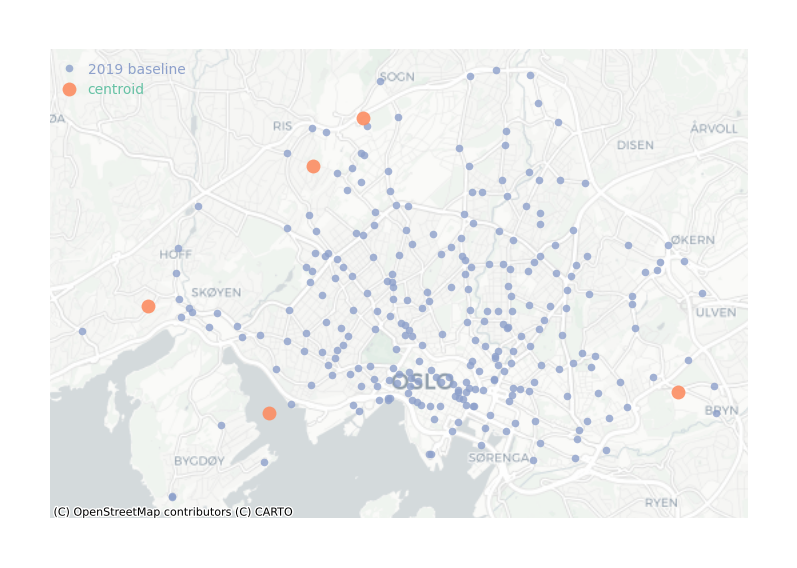

In [124]:
f, ax = plt.subplots(1, figsize=(9, 9))
stations_2024.plot(alpha=0.8, ax=ax, color='#8da0cb', markersize=30, label='2019 baseline')
gdf_centroids.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=100, label='centroid')

ax.set_axis_off()
plt.legend(labelcolor= ['#8da0cb','#66c2a5', '#fc8d62'],loc='upper left')
cx.add_basemap(ax, crs=stations_2024.crs, source=cx.providers.CartoDB.Positron)

## Find new stations 2ed try

In [6]:
df = pd.read_csv(f'{_path}/preprocessed_bike_rides.csv')
gdf_stations = create_stations_gdf(df)
# stations_filtered = gdf_stations.drop_duplicates(subset='station_id')

In [7]:
# Split the stations GeoDataFrame by year
gdf_stations_by_year = {}
difference_stations_by_year = {}

for year in range(19, 25):
    gdf_stations_by_year[year] = gdf_stations[gdf_stations['year'] == year]

In [8]:
k = 3

# unique stations of 2024
stations_2024 = gdf_stations_by_year[24].drop_duplicates(subset='station_id')
stations_2024

station_id        station_name              station_description  \
6360135         403           Parkveien                ved trikkestoppet   
6360136         464         Sukkerbiten                    ved gangbroen   
6360137         426          Gimle Kino                ved Frogner Kirke   
6360138         394   Bjølsen Studentby                ved rundkjøringen   
6360139         521  Jess Carlsens gate               ved Hausmanns gate   
...             ...                 ...                              ...   
6394825         545         Arkaden Sør           langs Dronningens gate   
6398328         551     Olaf Ryes plass             langs Sofienberggata   
6422242         576    Dronningens gate               sør for Karl Johan   
6833639         508   Majorstuen T-bane  ved passasje mot Sørkedalsveien   
6864862         549        Linaaes gate                 langs Møllergata   

          latitude  longitude  month  year                         geometry  
6360135  59.921768  10.730476      4    24  POINT (1194511.124 8382340.955)  
6360136  59.905124  10.753764      4    24  POINT (1197103.483 8378645.102)  
6360137  59.917281  10.708376      4    24  POINT (1192050.941 8381344.349)  
6360138  59.943778  10.760121      4    24  POINT (1197811.205 8387231.202)  
6360139  59.918636  10.752394      4    24  POINT (1196951.014 8381645.305)  
...            ...        ...    ...   ...                              ...  
6394825  59.911969  10.747858      4    24  POINT (1196446.113 8380164.804)  
6398328  59.922425  10.758182      4    24  POINT (1197595.342 8382486.885)  
6422242  59.911392  10.747282      4    24  POINT (1196381.941 8380036.728)  
6833639  59.929857  10.714566      2    24  POINT (1192740.058 8384137.907)  
6864862  59.913824  10.745704      1    24  POINT (1196206.351 8380576.678)  

[268 rows x 8 columns]

In [76]:
import geopandas as gpd
from shapely.geometry import Polygon
from itertools import combinations

# Step 1: Create all possible combinations of k stations
combinations_of_stations = list(combinations(stations_2024.geometry, k))

# Step 2: Create polygons with progress bar
polygons = [Polygon(points) for points in tqdm(combinations_of_stations)]

# Step 3: Store polygons in a new GeoDataFrame
gdf_polygons = gpd.GeoDataFrame({'geometry': polygons}, crs=stations_2024.crs)
gdf_polygons

100%|██████████| 3280455/3280455 [03:26<00:00, 15884.48it/s]


geometry
0        POLYGON ((1194511.124 8382340.955, 1197103.483...
1        POLYGON ((1194511.124 8382340.955, 1197103.483...
2        POLYGON ((1194511.124 8382340.955, 1197103.483...
3        POLYGON ((1194511.124 8382340.955, 1197103.483...
4        POLYGON ((1194511.124 8382340.955, 1197103.483...
...                                                    ...
3280450  POLYGON ((1192740.058 8384137.907, 1192988.920...
3280451  POLYGON ((1196206.351 8380576.678, 1187488.663...
3280452  POLYGON ((1196206.351 8380576.678, 1187488.663...
3280453  POLYGON ((1196206.351 8380576.678, 1192988.920...
3280454  POLYGON ((1187488.663 8380461.971, 1192988.920...

[3280455 rows x 1 columns]

In [77]:
# Calculate the centroids of all polygons
gdf_polygons['centroid'] = gdf_polygons['geometry'].centroid

In [78]:
c = 3
from scipy.spatial import cKDTree
import numpy as np

# Step 1: Calculate the distance from each centroid to its closest c stations
tree = cKDTree(np.array(list(zip(stations_2024.geometry.x, stations_2024.geometry.y))))
distances, indices = tree.query(np.array(list(zip(gdf_polygons['centroid'].x, gdf_polygons['centroid'].y))), k=c)

# Step 2: Find the 5 centroid points that have the largest minimum distance to the c closest stations
min_distances = distances.min(axis=1)
furthest_centroids = gdf_polygons['centroid'].loc[np.argsort(min_distances)[-1:]]

In [79]:
furthest_centroids

3191569    POINT (1190094.577 8384004.735)
Name: centroid, dtype: geometry

In [80]:
# Create a new GeoDataFrame for furthest_centroids
gdf_furthest_centroids = gpd.GeoDataFrame(furthest_centroids, geometry='centroid', crs=stations_2024.crs)

In [72]:
# rename centroid to geometry
gdf_furthest_centroids = gdf_furthest_centroids.rename(columns={'centroid': 'geometry'})

In [73]:
# Add the new points to stations_2024
stations_2024 = pd.concat([stations_2024, gdf_furthest_centroids])

In [74]:
stations_2024

station_id        station_name              station_description  \
6360135       403.0           Parkveien                ved trikkestoppet   
6360136       464.0         Sukkerbiten                    ved gangbroen   
6360137       426.0          Gimle Kino                ved Frogner Kirke   
6360138       394.0   Bjølsen Studentby                ved rundkjøringen   
6360139       521.0  Jess Carlsens gate               ved Hausmanns gate   
...             ...                 ...                              ...   
6833639       508.0   Majorstuen T-bane  ved passasje mot Sørkedalsveien   
6864862       549.0        Linaaes gate                 langs Møllergata   
773509          NaN                 NaN                              NaN   
1136425         NaN                 NaN                              NaN   
787734          NaN                 NaN                              NaN   

          latitude  longitude  month  year                         geometry  
6360135  59.921768  10.730476    4.0  24.0  POINT (1194511.124 8382340.955)  
6360136  59.905124  10.753764    4.0  24.0  POINT (1197103.483 8378645.102)  
6360137  59.917281  10.708376    4.0  24.0  POINT (1192050.941 8381344.349)  
6360138  59.943778  10.760121    4.0  24.0  POINT (1197811.205 8387231.202)  
6360139  59.918636  10.752394    4.0  24.0  POINT (1196951.014 8381645.305)  
...            ...        ...    ...   ...                              ...  
6833639  59.929857  10.714566    2.0  24.0  POINT (1192740.058 8384137.907)  
6864862  59.913824  10.745704    1.0  24.0  POINT (1196206.351 8380576.678)  
773509         NaN        NaN    NaN   NaN  POINT (1187488.663 8380461.971)  
1136425        NaN        NaN    NaN   NaN  POINT (1192988.920 8377864.960)  
787734         NaN        NaN    NaN   NaN  POINT (1187404.949 8378749.276)  

[271 rows x 8 columns]

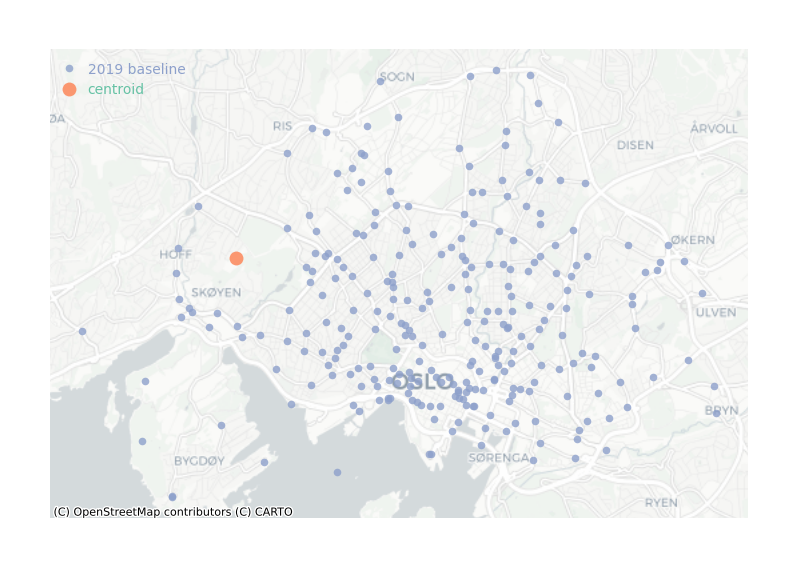

In [82]:
f, ax = plt.subplots(1, figsize=(9, 9))
stations_2024.plot(alpha=0.8, ax=ax, color='#8da0cb', markersize=30, label='2019 baseline')
gdf_furthest_centroids.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=100, label='centroid')

ax.set_axis_off()
plt.legend(labelcolor= ['#8da0cb','#66c2a5', '#fc8d62'],loc='upper left')
cx.add_basemap(ax, crs=stations_2024.crs, source=cx.providers.CartoDB.Positron)

In [10]:
# get first point of stations 24
first_station = stations_2024.iloc[0]
first_station

station_id                                                     403
station_name                                             Parkveien
station_description                              ved trikkestoppet
latitude                                                 59.921768
longitude                                                10.730476
month                                                            4
year                                                            24
geometry               POINT (1194511.124289443 8382340.954972156)
Name: 6360135, dtype: object

In [17]:
import osmnx as ox

# Define the area of interest
area_of_interest = 'Oslo, Norway'

# Download the OSM data for water in the area of interest
gdf_water = ox.geometries_from_place(area_of_interest, tags={'natural':'water'})

# Check if the points are in water
first_station['in_water'] = any(first_station['geometry'].within(polygon) for polygon in gdf_water['geometry'])
first_station

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_42393/3992512386.py:7: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf_water = ox.geometries_from_place(area_of_interest, tags={'natural':'water'})
/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_42393/3992512386.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_station['in_water'] = any(first_station['geometry'].within(polygon) for polygon in gdf_water['geometry'])


station_id                                                     403
station_name                                             Parkveien
station_description                              ved trikkestoppet
latitude                                                 59.921768
longitude                                                10.730476
month                                                            4
year                                                            24
geometry               POINT (1194511.124289443 8382340.954972156)
in_water                                                     False
Name: 6360135, dtype: object